# Kaggle HMS-HBAC Competition (2D spectrogram + 1D CNN)
* Sangwon Baek, Dokyun Yoon 
* March 5th 2024 

* Import Necessary Library

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import random 
import math
import multiprocessing
import time

import sys
sys.path.append('Scripts')
from kaggle_kl_div import score

from sklearn import model_selection
from sklearn.model_selection import *
from scipy.signal import butter, lfilter

import torch
import torch.nn as nn
import torch.multiprocessing as mp
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping
from torch.utils.data import Dataset, DataLoader
import torch_audiomentations as tA
from torch_audiomentations import Compose, Gain, PolarityInversion
import torchvision.transforms as transforms
import torchvision.io 
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR

from braindecode.augmentation import AugmentedDataLoader, SignFlip, FrequencyShift, ChannelsDropout,ChannelsShuffle
from braindecode.augmentation import Transform

import librosa
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import gc
import timm 
from tqdm import tqdm
from typing import Dict, List

import warnings
warnings.filterwarnings('ignore')

import os
import certifi

os.environ['SSL_CERT_FILE'] = certifi.where()

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')

Using 1 GPU(s)


* Read and Preprocess Data (Train, RAW_EEG, EEG_Spec, Kaggle_Spec)

In [108]:
class Config:
    AMP = True
    BATCH_SIZE_TRAIN = 32
    BATCH_SIZE_VALID = 32
    EPOCHS = 4
    FOLDS = 5
    FREEZE = False
    GRADIENT_ACCUMULATION_STEPS = 1
    MAX_GRAD_NORM = 1e7
    MODEL = "tf_efficientnet_b0"
    NUM_FROZEN_LAYERS = 39
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 0
    TRAIN_FULL_DATA = False
    VISUALIZE = True
    WEIGHT_DECAY = 0.01

class Path:
    OUTPUT_DIR = "../Results"
    TRAIN_CSV = "../Data/original_data/train.csv"
    TRAIN_RAW_EEGS = "../Data/original_data/train_eegs/"
    TRAIN_EEG_SPECTROGRAM = "../Data/spec/EEG_Spectrograms/"
    TRAIN_SPECTOGRAMS = "../Data/original_data/train_spectrograms/"
    PRE_LOADED_RAW_EEGS = "../Data/raw_eeg/eegs.npy" 
    PRE_LOADED_EEG_SPECTROGRAMS = "../Data/spec/eeg_specs.npy" 
    PRE_LOADED_SPECTROGRAMS = "../Data/kagglespec/specs.npy"
    


In [109]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_logger(filename=Path.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def plot_spectrogram(spectrogram_path: str):
    """
    Source: https://www.kaggle.com/code/mvvppp/hms-eda-and-domain-journey
    Visualize spectogram recordings from a parquet file.
    :param spectrogram_path: path to the spectogram parquet.
    """
    sample_spect = pd.read_parquet(spectrogram_path)
    
    split_spect = {
        "LL": sample_spect.filter(regex='^LL', axis=1),
        "RL": sample_spect.filter(regex='^RL', axis=1),
        "RP": sample_spect.filter(regex='^RP', axis=1),
        "LP": sample_spect.filter(regex='^LP', axis=1),
    }
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()
    label_interval = 5
    for i, split_name in enumerate(split_spect.keys()):
        ax = axes[i]
        img = ax.imshow(np.log(split_spect[split_name]).T, cmap='viridis', aspect='auto', origin='lower')
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('Log(Value)')
        ax.set_title(split_name)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time")

        ax.set_yticks(np.arange(len(split_spect[split_name].columns)))
        ax.set_yticklabels([column_name[3:] for column_name in split_spect[split_name].columns])
        frequencies = [column_name[3:] for column_name in split_spect[split_name].columns]
        ax.set_yticks(np.arange(0, len(split_spect[split_name].columns), label_interval))
        ax.set_yticklabels(frequencies[::label_interval])
    plt.tight_layout()
    plt.show()
    
    
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 

    
def sep():
    print("-"*100)
    

target_preds = [x + "_pred" for x in ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other':5}
num_to_label = {v: k for k, v in label_to_num.items()}
LOGGER = get_logger()
seed_everything(Config.SEED)

In [110]:
def config_to_dict(cfg):
    return dict((name, getattr(cfg, name)) for name in dir(cfg) if not name.startswith('__'))

def create_train_df():
    TARGETS = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]

    df = pd.read_csv(Path.TRAIN_CSV)

    # Create a new identifier combining multiple columns
    id_cols = ['eeg_id', 'spectrogram_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    df['new_id'] = df[id_cols].astype(str).agg('_'.join, axis=1)
    
    # Calculate the sum of votes for each class
    df['sum_votes'] = df[TARGETS].sum(axis=1)
    
    # Group the data by the new identifier and aggregate various features
    agg_functions = {
        'eeg_id': 'first',
        'eeg_label_offset_seconds': ['min', 'max'],
        'spectrogram_label_offset_seconds': ['min', 'max'],
        'spectrogram_id': 'first',
        'patient_id': 'first',
        'expert_consensus': 'first',
        **{col: 'sum' for col in TARGETS},
        'sum_votes': 'sum',
    }
    grouped_df = df.groupby('new_id').agg(agg_functions).reset_index()

    # Flatten the MultiIndex columns and adjust column names
    grouped_df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in grouped_df.columns]
    grouped_df.columns = grouped_df.columns.str.replace('_first', '').str.replace('_sum', '')
    
    # Normalize the class columns
    y_data = grouped_df[TARGETS].values
    y_data_normalized = y_data / y_data.sum(axis=1, keepdims=True)
    grouped_df[TARGETS] = y_data_normalized

    # Split the dataset into high and low quality based on the sum of votes
    high_quality_df = grouped_df[grouped_df['sum_votes'] >= 10].reset_index(drop=True)
    low_quality_df = grouped_df[(grouped_df['sum_votes'] < 10) & (grouped_df['sum_votes'] >= 0)].reset_index(drop=True)

    return high_quality_df, low_quality_df, grouped_df

def eeg_from_parquet(parquet_path, display=False):
    
    # EXTRACT MIDDLE 50 SECONDS
    eeg = pd.read_parquet(parquet_path, columns=FEATS)
    rows = len(eeg)
    offset = (rows-10_000)//2
    eeg = eeg.iloc[offset:offset+10_000]
    
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    
    # CONVERT TO NUMPY
    data = np.zeros((10_000,len(FEATS)))
    for j,col in enumerate(FEATS):
        
        # FILL NAN
        x = eeg[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
        else: x[:] = 0
            
        data[:,j] = x
        
        if display: 
            if j!=0: offset += x.max()
            plt.plot(range(10_000),x-offset,label=col)
            offset -= x.min()
            
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1]
        name = name.split('.')[0]
        plt.title(f'EEG {name}',size=16)
        plt.show()
        
    return data


In [111]:
if not os.path.exists(Path.OUTPUT_DIR):
    os.makedirs(Path.OUTPUT_DIR)
    print(f"Directory has been made {Path.OUTPUT_DIR}")
pl.seed_everything(Config.SEED, workers=True)

Seed set to 0


0

In [112]:
# Configuration for model training
FOLDS = 5
EPOCHS = 4
BATCH = 32
NAME = 'None'

SPEC_SIZE  = (512, 512, 3)
TARGETS = CLASSES = ["seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote"]
Config.num_classes = num_classes = len(CLASSES)

# Preprocess dataset 
high_quality_df, low_quality_df, grouped_df = create_train_df()
train_df = grouped_df
label_cols = grouped_df.columns[-6:]
print(f"Train cataframe shape is: {grouped_df.shape}")
print(f"Labels: {list(label_cols)}")
grouped_df.head()

Train cataframe shape is: (20183, 16)
Labels: ['lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote', 'sum_votes']


,new_id,eeg_id,eeg_label_offset_seconds_min,eeg_label_offset_seconds_max,spectrogram_label_offset_seconds_min,spectrogram_label_offset_seconds_max,spectrogram_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,sum_votes
0,1000913311_175871552_0_0_0_0_0_2,1000913311,0.0,0.0,0.0,0.0,175871552,59743,Other,0.0,0.000000,0.000000,0.0,0.0,1.000000,2
1,1001369401_2126584909_0_1_0_0_0_2,1001369401,0.0,0.0,0.0,0.0,2126584909,34339,Other,0.0,0.333333,0.000000,0.0,0.0,0.666667,3
2,1001369401_2126584909_0_3_0_0_0_18,1001369401,6.0,6.0,6.0,6.0,2126584909,34339,Other,0.0,0.142857,0.000000,0.0,0.0,0.857143,21
3,1001487592_1662440941_0_1_11_0_0_0,1001487592,0.0,8.0,0.0,8.0,1662440941,42165,GPD,0.0,0.083333,0.916667,0.0,0.0,0.000000,48
4,1001717358_190818600_3_0_0_0_0_0,1001717358,0.0,154.0,0.0,154.0,190818600,28197,Seizure,1.0,0.000000,0.000000,0.0,0.0,0.000000,30


In [113]:
# Data Reader 
CREATE_EEGS = True
df_eeg = pd.read_parquet(f'{Path.TRAIN_RAW_EEGS}1000913311.parquet')
FEATS = df_eeg.columns
EEG_IDS = grouped_df.eeg_id.unique()
print(f'There are {len(FEATS)} raw eeg features')
print(list(FEATS))

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


In [114]:
%%time

if Path.PRE_LOADED_RAW_EEGS is not None:
    raw_eegs = np.load(Path.PRE_LOADED_RAW_EEGS, allow_pickle=True).item()
else:

    all_eegs = {}
    DISPLAY = 4
    EEG_IDS = train.eeg_id.unique()
    PATH = f'{Path.data_root}train_eegs/'
    
    for i,eeg_id in enumerate(EEG_IDS):
        if (i%100==0)&(i!=0): print(i,', ',end='') 
        
        # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
        data = eeg_from_parquet(f'{PATH}{eeg_id}.parquet', display=i<DISPLAY)              
        all_eegs[eeg_id] = data
        
        if i==DISPLAY:
            if CREATE_EEGS:
                print(f'Processing {train.eeg_id.nunique()} eeg parquets... ',end='')
            else:
                print(f'Reading {len(EEG_IDS)} eeg NumPys from disk.')
                break
                
    if CREATE_EEGS: 
        np.save(f'{Path.OUTPUT_DIR}eegs_20ch',all_eegs)
        
print(f"Length of eegs: {len(raw_eegs)}")

READ_SPEC_FILES = False
paths_spectrograms = glob(Path.TRAIN_SPECTOGRAMS + "*.parquet")
print(f'There are {len(paths_spectrograms)} spectrogram parquets')

if READ_SPEC_FILES:    
    all_spectrograms = {}
    for file_path in tqdm(paths_spectrograms):
        aux = pd.read_parquet(file_path)
        name = int(file_path.split("/")[-1].split('.')[0])
        all_spectrograms[name] = aux.iloc[:,1:].values
        del aux
else:
    all_spectrograms = np.load(Path.PRE_LOADED_SPECTROGRAMS, allow_pickle=True).item()

READ_EEG_SPEC_FILES = False
paths_eegs = glob(Path.TRAIN_EEG_SPECTROGRAM + "*.npy")
print(f'There are {len(paths_eegs)} EEG spectrograms')

if READ_EEG_SPEC_FILES:
    all_eegs = {}
    for file_path in tqdm(paths_eegs):
        eeg_id = file_path.split("/")[-1].split(".")[0]
        eeg_spectrogram = np.load(file_path)
        all_eegs[eeg_id] = eeg_spectrogram
else:
    all_eegs = np.load(Path.PRE_LOADED_EEG_SPECTROGRAMS, allow_pickle=True).item()

print(f"Shape of Kaggle spectrograms: {all_spectrograms[train_df.loc[0,'spectrogram_id']].shape}")
print(f"Shape of EEG spectrograms: {all_eegs[train_df.loc[0,'eeg_id']].shape}")
print(f"Shape of raw eegs: {raw_eegs[train_df.loc[0,'eeg_id']].shape}")

Length of eegs: 17089
There are 11138 spectrogram parquets
There are 17089 EEG spectrograms
Shape of Kaggle spectrograms: (300, 400)
Shape of EEG spectrograms: (128, 256, 4)
Shape of raw eegs: (10000, 8)
CPU times: total: 24.9 s
Wall time: 51 s


* Create Spectrogram (2D) Dataset for training 

In [115]:
def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    # bins = np.linspace(-1, 1, classes)
    # quantized = np.digitize(mu_x, bins) - 1
    return mu_x#quantized

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


In [116]:
class CustomDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame, Config,
        augment: bool = False, mode: str = 'train',
        specs: Dict[int, np.ndarray] = all_spectrograms,
        eeg_specs: Dict[int, np.ndarray] = all_eegs
    ): 
        self.df = df
        self.Config = Config
        self.batch_size = self.Config.BATCH_SIZE_TRAIN
        self.augment = augment
        self.mode = mode
        self.spectograms = all_spectrograms
        self.eeg_spectograms = eeg_specs
        
    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Generate one batch of data.
        """
        X, y = self.__data_generation(index)
        if self.augment:
            X = self.__transform(X) 
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
                        
    def __data_generation(self, index):
        """
        Generates data containing batch_size samples.
        """
        X = np.zeros((128, 256, 8), dtype='float32')
        y = np.zeros(6, dtype='float32')
        img = np.ones((128,256), dtype='float32')
        row = self.df.iloc[index]
        if self.mode=='test': 
            r = 0
        else: 
            r = int((row['spectrogram_label_offset_seconds_min'] + row['spectrogram_label_offset_seconds_max']) // 4)
            
        for region in range(4):
            img = self.spectograms[row.spectrogram_id][r:r+300, region*100:(region+1)*100].T
            
            # Log transform spectogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)

            # Standarize per image
            ep = 1e-6
            mu = np.nanmean(img.flatten())
            std = np.nanstd(img.flatten())
            img = (img-mu)/(std+ep)
            img = np.nan_to_num(img, nan=0.0)
            X[14:-14, :, region] = img[:, 22:-22] / 2.0
            img = self.eeg_spectograms[row.eeg_id]
            X[:, :, 4:] = img
                
            if self.mode != 'test':
                y = row[label_cols].values.astype(np.float32)
            
        return X, y
    
    def __transform(self, img):
        transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
        ])
        return transforms(image=img)['image']

In [117]:
train_dataset = CustomDataset(train_df, Config, mode="train")
train_loader = DataLoader(
    train_dataset,
    batch_size=Config.BATCH_SIZE_TRAIN,
    shuffle=False,
    num_workers=Config.NUM_WORKERS, pin_memory=True, drop_last=True
)
X, y = train_dataset[0]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([128, 256, 8])
y shape: torch.Size([6])


In [118]:
class SpectrogramModel(nn.Module):
    def __init__(self, config, num_classes: int = 6, pretrained: bool = True):
        super(SpectrogramModel, self).__init__()
        self.USE_KAGGLE_SPECTROGRAMS = True
        self.USE_EEG_SPECTROGRAMS = True
        self.model = timm.create_model(
            config.MODEL,
            pretrained=pretrained,
            drop_rate = 0.1,
            drop_path_rate = 0.2,
        )
        if config.FREEZE:
            for i,(name, param) in enumerate(list(self.model.named_parameters())\
                                             [0:config.NUM_FROZEN_LAYERS]):
                param.requires_grad = False

        self.features = nn.Sequential(*list(self.model.children())[:-2])
        self.custom_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(self.model.num_features, num_classes)
        )

    def __reshape_input(self, x):
        """
        Reshapes input (128, 256, 8) -> (512, 512, 3) monotone image.
        """ 
        # === Get spectograms ===
        spectograms = [x[:, :, :, i:i+1] for i in range(4)]
        spectograms = torch.cat(spectograms, dim=1)
        
        # === Get EEG spectograms ===
        eegs = [x[:, :, :, i:i+1] for i in range(4,8)]
        eegs = torch.cat(eegs, dim=1)
        
        # === Reshape (512,512,3) ===
        if self.USE_KAGGLE_SPECTROGRAMS & self.USE_EEG_SPECTROGRAMS:
            x = torch.cat([spectograms, eegs], dim=2)
        elif self.USE_EEG_SPECTROGRAMS:
            x = eegs
        else:
            x = spectograms
            
        x = torch.cat([x,x,x], dim=3)
        x = x.permute(0, 3, 1, 2)
        return x
    
    def forward(self, x):
        x = self.__reshape_input(x)
        x = self.features(x)
        x = self.custom_layers(x)
        return x

In [1]:
import timm

In [119]:
EPOCHS = Config.EPOCHS
BATCHES = len(train_loader)
steps = []
lrs = []
optim_lrs = []
model = SpectrogramModel(Config)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = OneCycleLR(
    optimizer,
    max_lr=1e-3,
    epochs=Config.EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.05,
    anneal_strategy="cos",
    final_div_factor=100,
)

for epoch in range(EPOCHS):
    for batch in range(BATCHES):
        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])
        steps.append(epoch * BATCHES + batch)

max_lr = max(lrs)
min_lr = min(lrs)
print(f"Maximum LR: {max_lr} | Minimum LR: {min_lr}")
plt.figure()
plt.plot(steps, lrs, label='OneCycle')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.show()

SSLError: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /timm/tf_efficientnet_b0.ns_jft_in1k/resolve/main/model.safetensors (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)')))"), '(Request ID: 69162e7f-0d28-42ba-a46f-22f76bf5e64e)')

In [10]:
# class EEGDataset(torch.utils.data.Dataset):
#     def __init__(self, data, eegs=None, specs=None, eeg_specs=None, spec_aug = False, augmentations=None, test=False): 
#         self.data = data
#         self.eegs = eegs
#         self.specs = specs  # Spectrograms for each ID
#         self.eeg_specs = eeg_specs  # EEG spectrograms for each ID
#         self.augmentations = augmentations
#         self.test = test
#         self.spec_aug = spec_aug
        
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, index):
#         row = self.data.iloc[index]
        
#         # Processing EEG signal data
#         eeg_data = self.eegs[row.eeg_id]
#         sample = np.zeros((eeg_data.shape[0], 8))  # Assuming eeg_data.shape[1] == 8 for 8 channels
#         FEAT2IDX = {'Fp1': 0, 'T3': 1, 'C3': 2, 'O1': 3, 'Fp2': 4, 'C4': 5, 'T4': 6, 'O2': 7}
        
#         # Compute differences
#         for i, (start, end) in enumerate([('Fp1', 'T3'), ('T3', 'O1'), ('Fp1', 'C3'), ('C3', 'O1'), 
#                                           ('Fp2', 'C4'), ('C4', 'O2'), ('Fp2', 'T4'), ('T4', 'O2')]):
#             sample[:, i] = eeg_data[:, FEAT2IDX[start]] - eeg_data[:, FEAT2IDX[end]]
        
#         sample = self.process_sample(sample)
        
#         samples = torch.from_numpy(sample).float()
#         samples = samples.permute(1, 0)
        
#         # Processing spectrogram data
#         spec = self.__spec_data_generation(row)
#         if self.spec_aug:
#             spec = self.__transform(spec) 
        
#         if not self.test:
#             label = row[TARGETS]  # Assuming 'TARGETS' is defined somewhere as the label column name
#             label = torch.tensor(label).float()  
#             return samples, spec, label
#         else:
#             return samples, spec
    
#     def process_sample(self, sample):
#         # Normalize the sample data
#         sample = (sample - np.mean(sample, axis=0)) / np.std(sample, axis=0)
#         sample = np.clip(sample, -1024, 1024)
#         sample = np.nan_to_num(sample, nan=0)
#         sample = butter_lowpass_filter(sample)
#         sample = quantize_data(sample, 1)
#         return sample

#     def __spec_data_generation(self, row):
#         """
#         Generates data containing batch_size samples. This method directly
#         uses class attributes for spectrograms and EEG spectrograms.
#         """
#         X = np.zeros((128, 256, 8), dtype='float32')        
#         if 'min' in row and 'max' in row:
#             # Assuming your DataFrame has a column that combines min and max values for slicing
#             r = int((row['min'] + row['max']) // 4)
#         else:
#             r = 0  # Adjust as necessary for test mode
        
#         for region in range(4):
#             img = self.specs[row.spectrogram_id][r:r+300, region*100:(region+1)*100].T
            
#             # Log transform spectrogram
#             img = np.clip(img, np.exp(-4), np.exp(8))
#             img = np.log(img)

#             # Standarize per image
#             ep = 1e-6
#             mu = np.nanmean(img.flatten())
#             std = np.nanstd(img.flatten())
#             img = (img-mu)/(std+ep)
#             img = np.nan_to_num(img, nan=0.0)
#             X[14:-14, :, region] = img[:, 22:-22] / 2.0
        
#         # Process EEG spectrogram - assuming a single channel example
#         img = self.eeg_specs[row.eeg_id]
#         X[:, :, 4:] = img                
#         return X

#     def __transform(self, img):
#         transforms = A.Compose([
#             A.HorizontalFlip(p=0.5),
#         ])
#         return transforms(image=img)['image']



In [11]:
def get_train_transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
                A.Cutout(max_h_size=5, max_w_size=16),
                A.CoarseDropout(max_holes=4),
            ], p=0.5),
    ])

def get_transforms(*, data):
    
    if data == 'train':
        return tA.Compose(
                transforms=[
                     # tA.ShuffleChannels(p=0.25,mode="per_channel",p_mode="per_channel",),
                     tA.AddColoredNoise(p=0.15,mode="per_channel",p_mode="per_channel", max_snr_in_db = 15, sample_rate=200),
                     tA.Shift(p=0.5,mode="per_example",p_mode="per_example",max_shift=0.025, min_shift=-0.025,sample_rate=200),
                ])

    elif data == 'valid':
        return tA.Compose([])
    
freq_shift = FrequencyShift(
    probability=.3,
    sfreq=200,
    max_delta_freq=2.  # the frequency shifts are sampled now between -2 and 2 Hz
)

ch_drop = ChannelsDropout(probability=0.2, p_drop=0.2)
sign_flip = SignFlip(probability=.1)
ch_shuffle = ChannelsShuffle(probability=0.25)

transforms = [
    freq_shift,
    sign_flip,
]

class Compose(Transform):

    def __init__(self, transforms):
        self.transforms = transforms
        super().__init__()

    def forward(self, X, y):
        for transform in self.transforms:
            X = transform(X, None)
        return X, y

def get_transforms(*, data):
    if data == 'train':
        return Compose(
                transforms=transforms)
    elif data == 'valid':
        return Compose([
        ])

In [12]:
def get_fold_dls(df_train, df_valid):

    ds_train = EEGDataset(
        df_train, 
        eegs=raw_eegs,
        specs=all_spectrograms,
        eeg_specs=all_eegs,
        augmentations = get_transforms(data='train'),
        test = False
    )
    
    ds_val = EEGDataset(
        df_valid, 
        eegs=raw_eegs,
        specs=all_spectrograms,
        eeg_specs=all_eegs,
        augmentations = get_transforms(data='valid'),
        test = False
    )
    dl_train = DataLoader(ds_train, batch_size=Config.batch_size , shuffle=True, num_workers = 2)    
    dl_val = DataLoader(ds_val, batch_size=Config.batch_size, num_workers = 2)
    return dl_train, dl_val, ds_train, ds_val

def show_eeg_batch(img_ds, num_items, num_rows, num_cols, EEG_IDS, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first items
        img,spec, lb = img_ds[img_index]    
        print(spec.shape)
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
            img = img.transpose(1,0)
        offset = 0
        for j in range(img.shape[-1]):
            if j != 0: offset -= img[:, j].min()
            ax.plot(img[:, j] + offset, label=f'feature {j+1}')
            offset += img[:, j].max() + 1  # Adding 1 for visual separation

        ax.legend()
        ax.set_title(f'EEG_Id = {EEG_IDS[img_index]}', size=14)

    plt.tight_layout()
    plt.show()

In [81]:
# Conduct Group K fold with 5 folds to create a column named 'fold' with 5 discrete folds 
gkf = GroupKFold(n_splits=5)
grouped_df['fold'] = 0
for fold, (tr_idx, val_idx) in enumerate(gkf.split(grouped_df, grouped_df.expert_consensus, grouped_df.patient_id)):   
    grouped_df.loc[val_idx, 'fold'] = fold

#Create temp train and valid sets 
temp_train = grouped_df[grouped_df['fold']!=0].copy()
temp_valid = grouped_df[grouped_df['fold']==0].copy()

(128, 256, 8)
(128, 256, 8)
(128, 256, 8)
(128, 256, 8)
(128, 256, 8)
(128, 256, 8)
(128, 256, 8)
(128, 256, 8)


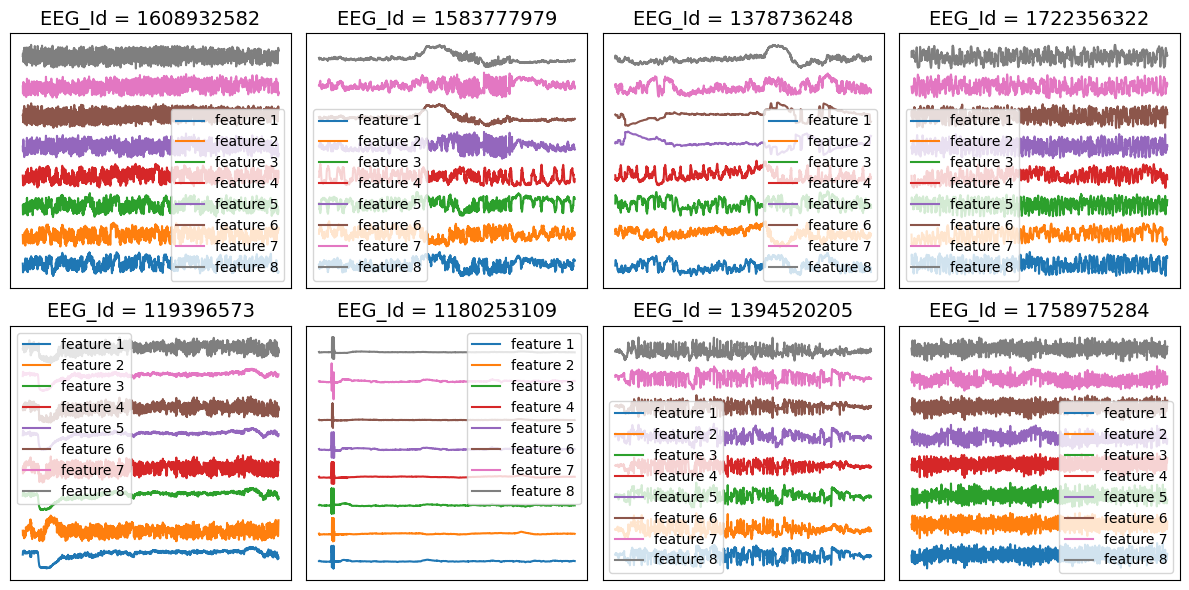

In [14]:
# Get fold and show batch
dl_train, dl_val, ds_train, ds_val = get_fold_dls(temp_train, temp_valid)
show_eeg_batch(ds_val, 8, 2, 4, EEG_IDS)

# dl_train, dl_val, ds_train, ds_val = get_fold_dls(temp_train, temp_valid)
# show_batch(ds_train, 8, 2, 4, EEG_IDS)

In [15]:
class ResNet_1D_Block(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling):
        super(ResNet_1D_Block, self).__init__()
        self.bn1 = nn.BatchNorm1d(num_features=in_channels)
        self.relu = nn.ReLU(inplace=False)
        self.dropout = nn.Dropout(p=0.1, inplace=False)
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(num_features=out_channels)
        self.conv2 = nn.Conv1d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.downsampling = downsampling

    def forward(self, x):
        identity = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv1(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)

        out = self.maxpool(out)
        identity = self.downsampling(x)

        out += identity
        return out

In [16]:
class EEGMegaNet(nn.Module):

    def __init__(self, backbone_2d,in_channels_2d, kernels, pretrained=False, in_channels=20, fixed_kernel_size=17, num_classes=6):
        super(EEGMegaNet, self).__init__()
        
        self.kernels = kernels
        self.planes = 24
        self.parallel_conv = nn.ModuleList()
        self.in_channels = in_channels

        self.backbone_2d = timm.create_model(
            Config.backbone_2d,
            pretrained=pretrained,
            drop_rate = 0.1,
            drop_path_rate = 0.1
        )
        
        self.features_2d = nn.Sequential(*list(self.backbone_2d.children())[:-2] + [nn.AdaptiveAvgPool2d(1),nn.Flatten()])

        for i, kernel_size in enumerate(list(self.kernels)):
            sep_conv = nn.Conv1d(in_channels=in_channels, out_channels=self.planes, kernel_size=(kernel_size),
                               stride=1, padding=0, bias=False,)
            self.parallel_conv.append(sep_conv)

        self.bn1 = nn.BatchNorm1d(num_features=self.planes)
        self.relu = nn.ReLU(inplace=False)
        self.conv1 = nn.Conv1d(in_channels=self.planes, out_channels=self.planes, kernel_size=fixed_kernel_size,
                               stride=2, padding=2, bias=False)
        self.block = self._make_resnet_layer(kernel_size=fixed_kernel_size, stride=1, padding=fixed_kernel_size//2)
        self.bn2 = nn.BatchNorm1d(num_features=self.planes)
        self.avgpool = nn.AvgPool1d(kernel_size=4, stride=4, padding=2)
        self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, num_layers=1, bidirectional=True)
        
        self.fc1 = nn.Linear(in_features=1280, out_features=128)
        self.fc2 = nn.Linear(in_features=736, out_features=128)
        self.fc = nn.Linear(in_features=256, out_features=num_classes)

        self.fc1d = nn.Linear(in_features=128, out_features=num_classes)
        self.fc2d = nn.Linear(in_features=128, out_features=num_classes)
        
        self.rnn1 = nn.GRU(input_size=156, hidden_size=156, num_layers=1, bidirectional=True)

    def _make_resnet_layer(self, kernel_size, stride, blocks=8, padding=0):
        layers = []
        downsample = None
        base_width = self.planes

        for i in range(blocks):
            downsampling = nn.Sequential(
                    nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
                )
            layers.append(ResNet_1D_Block(in_channels=self.planes, out_channels=self.planes, kernel_size=kernel_size,
                                       stride=stride, padding=padding, downsampling=downsampling))

        return nn.Sequential(*layers)

    def _reshape_input(self, spec):
        """
        Reshapes input (128, 256, 8) -> (512, 512, 3) monotone image.
        """ 
        # === Get spectrograms ===
        spectrograms = [spec[:, :, :, i:i+1] for i in range(4)]
        spectrograms = torch.cat(spectrograms, dim=1)
        
        # === Get EEG spectrograms ===
        eegs = [spec[:, :, :, i:i+1] for i in range(4,8)]
        eegs = torch.cat(eegs, dim=1)
        
        # === Reshape (512,512,3) ===
        spec = spectrograms
            
        spec = torch.cat([spec,spec,spec], dim=3)
        spec = spec.permute(0, 3, 1, 2)
        return spec

    def forward(self, x, spec):

        spec = self._reshape_input(spec)
        spec = self.features_2d(spec)
        # print(spec.shape) #2, 1280, 16, 8
        out_sep = []

        for i in range(len(self.kernels)):
            sep = self.parallel_conv[i](x)
            out_sep.append(sep)

        out = torch.cat(out_sep, dim=2)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv1(out)  

        out = self.block(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.avgpool(out)  

        out = out.reshape(out.shape[0], -1)  

        rnn_out, _ = self.rnn(x.permute(0,2, 1))
        new_rnn_h = rnn_out[:, -1, :]  

        new_out = torch.cat([out, new_rnn_h], dim=1)  
        new_out = self.fc2(new_out)  
        out1d = self.fc1d(new_out)
        
        spec = self.fc1(spec)  
        out2d = self.fc2d(spec)
        
        result = torch.cat([new_out, spec], dim=1)  
        result = self.fc(result)
        
        return result, new_out, spec, out1d, out2d

In [17]:
iot = torch.randn(2, Config.num_channels, 10000).cuda()
spec = torch.randn(2, 128, 256, 8).cuda()

model = EEGMegaNet(backbone_2d=Config.backbone_2d,in_channels_2d=8,
                   kernels=[3,5,7,9],pretrained=False,
                   in_channels=Config.num_channels, fixed_kernel_size=5,
                   num_classes=6).cuda()
output,_,_,_,_ = model(iot, spec)
print(output.shape)

del iot, model
gc.collect()

torch.Size([2, 6])


23695

In [18]:
def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=Config.weight_decay
        )
    interval = "epoch"
    
    lr_scheduler = CosineAnnealingWarmRestarts(
                            model_optimizer, 
                            T_0=Config.epochs, 
                            T_mult=1, 
                            eta_min=1e-7, 
                            last_epoch=-1
                        )

    return {
        "optimizer": model_optimizer, 
        "lr_scheduler": {
            "scheduler": lr_scheduler,
            "interval": interval,
            "monitor": "val_loss",
            "frequency": 1
        }
    }

In [34]:
# dummy = temp_valid.copy()
# dummy[TARGETS] = np.random.rand(dummy.shape[0],len(TARGETS))

# dummy[TARGETS] = dummy[TARGETS].div(dummy[TARGETS].sum(axis=1), axis=0)
# score(temp_valid[['eeg_id']+list(TARGETS)], dummy[['eeg_id']+list(TARGETS)],row_id_column_name='eeg_id')

In [19]:
class KLDivLossWithLogits(nn.KLDivLoss):

    def __init__(self):
        super().__init__(reduction="batchmean")

    def forward(self, y, t):
        y = nn.functional.log_softmax(y,  dim=1)
        loss = super().forward(y, t)

        return loss


In [20]:
class EEGModel(pl.LightningModule):
    def __init__(self, num_classes = Config.num_classes, pretrained = Config.pretrained, fold = fold):
        super().__init__()
        self.num_classes = num_classes
        self.fold = fold
        self.backbone = EEGMegaNet(backbone_2d=Config.backbone_2d,
                                   in_channels_2d=8,
                                   kernels=[3,5,7,9],pretrained=True,
                                   in_channels=Config.num_channels,
                                   fixed_kernel_size=5, num_classes=6)


        self.contrastive_loss = nn.CosineEmbeddingLoss()  # Using cosine similarity for contrastive loss

        self.loss_function = KLDivLossWithLogits() #nn.KLDivLoss() #nn.BCEWithLogitsLoss() 
        self.validation_step_outputs = []
        self.lin = nn.Softmax(dim=1)
        self.best_score = 1000.0

    def forward(self,eeg, spec):
        logits = self.backbone(eeg, spec)
        return logits
        
    def configure_optimizers(self):
        return get_optimizer(lr=Config.LR, params=self.parameters())

    def training_step(self, batch, batch_idx):
        eeg, spec, target = batch
        y_pred, embedding_1d, embedding_2d,yp1,yp2 = self(eeg, spec)
        classification_loss = self.loss_function(y_pred, target)
        
        classification_loss1 = self.loss_function(yp1, target)
        classification_loss2 = self.loss_function(yp2, target)
        

        # Calculate contrastive loss 
        embedding_1d = torch.nn.functional.normalize(embedding_1d, p=2, dim=1)
        embedding_2d = torch.nn.functional.normalize(embedding_2d, p=2, dim=1)

        
        contrastive_target = torch.ones(embedding_1d.size(0)).to(self.device)  # Assuming all pairs are similar
        contrastive_loss = self.contrastive_loss(embedding_1d, embedding_2d, contrastive_target)

        total_loss = classification_loss + classification_loss1*0.5 + classification_loss2*0.5 + contrastive_loss*0.5  # Aux losses

        self.log("train_loss", total_loss, on_step=True, on_epoch=True, prog_bar=True)
        return total_loss     

    def validation_step(self, batch, batch_idx):
        eeg, spec, target = batch 
        y_pred,_,_,y1d,y2d = self(eeg, spec)

        y_pred = y_pred*0.5 + y1d*0.25 + y2d*0.25
        val_loss = self.loss_function(y_pred, target)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.validation_step_outputs.append({"val_loss": val_loss, "logits": y_pred, "targets": target})

        return {"val_loss": val_loss, "logits": y_pred, "targets": target}
    
    def train_dataloader(self):
        return self._train_dataloader 
    
    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        # print(len(outputs))
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs],dim=0)).cpu().detach().numpy()
        target_val = torch.cat([x['targets'] for x in outputs],dim=0).cpu().detach().numpy()
        self.validation_step_outputs = []

        val_df = pd.DataFrame(target_val, columns = list(TARGETS))
        pred_df = pd.DataFrame(output_val, columns = list(TARGETS))

        val_df['id'] = [f'id_{i}' for i in range(len(val_df))] 
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))] 

        avg_score = avg_loss
        # avg_score = score(val_df, pred_df, row_id_column_name = 'id')

        if avg_score < self.best_score:
            print(f'Fold {self.fold}: Epoch {self.current_epoch} validation loss {avg_loss}')
            print(f'Fold {self.fold}: Epoch {self.current_epoch} validation KDL score {avg_score}')
            self.best_score = avg_score
            # val_df.to_csv(f'{Config.output_dir}/val_df_f{self.fold}.csv',index=False)
            # pred_df.to_csv(f'{Config.output_dir}/pred_df_f{self.fold}.csv',index=False)
        
        return {'val_loss': avg_loss,'val_cmap':avg_score}
    


In [21]:
def predict(data_loader, model):
        
    model.to('cuda')
    model.eval()    
    predictions = []
    for batch in tqdm(data_loader):

        with torch.no_grad():
            x,x2, y = batch
            x = x.cuda()
            x2 = x2.cuda()
            
            # inputs = {key:val.reshape(val.shape[0], -1).to(config.device) for key,val in batch.items()}
            outputs,_,_,y1,y2 = model(x, x2)
            
            outputs = outputs*0.5 + y1*0.25 + y2*0.25
            
            outputs = nn.Softmax(dim=1)(outputs)
        predictions.extend(outputs.detach().cpu().numpy())
    predictions = np.vstack(predictions)
    return predictions

def predict2(ds_test, model):
    
    model.to('cuda')
    model.eval()    
    predictions = []
    for en in tqdm(range(len(ds_test))):
        # print(en)
        x,_ = ds_test[en]
        x = x.unsqueeze(0).cuda()
        # print(images.shape)
        with torch.no_grad():
            outputs,_,_ = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
            outputs = outputs.detach().cpu().numpy()

        predictions.append(outputs)
        
    return predictions

In [22]:
from pytorch_lightning.loggers import WandbLogger
import gc
torch.set_float32_matmul_precision('high')
def run_training(fold_id, Config):
    print(f"Running training for fold {fold_id}...")
    logger = None
    pred_cols = [f'pred_{t}' for t in TARGETS]
    
    df_train = grouped_df[grouped_df['fold']!=fold_id].copy()
    df_valid = grouped_df[grouped_df['fold']==fold_id].copy()

    print(len(df_train),'train length')
    print(len(df_valid),'valid length')
    
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(df_train, df_valid)
    
    eeg_model = EEGModel(num_classes = Config.num_classes, pretrained = Config.pretrained, fold = fold_id)

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=Config.PATIENCE, verbose= True, mode="min")
    checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                          dirpath= f"{Config.output_dir}/",
                                      save_top_k=1,
                                      save_last= True,
                                      save_weights_only=False,
                                      filename= f'eegnet_best_loss_fold{fold_id}',
                                      verbose= True, mode='min')
    
    callbacks_to_use = [checkpoint_callback,early_stop_callback]


    trainer = pl.Trainer(
        # gpus=3,
        devices=[1],
        
        val_check_interval=0.5,
        deterministic=True,
        max_epochs=Config.epochs,
        # max_epochs=3,
        
        logger=logger,
        callbacks=callbacks_to_use,
        precision=Config.PRECISION,
        accelerator="gpu" 
    )
    

    print("Running trainer.fit")
    trainer.fit(eeg_model, train_dataloaders = dl_train, val_dataloaders = dl_val)                
    # trainer.

    model = EEGModel.load_from_checkpoint(f'{Config.output_dir}/eegnet_best_loss_fold{fold_id}.ckpt',train_dataloader=None,validation_dataloader=None,config=Config)    
    preds = predict(dl_val, model)  
    print(preds.shape)
    df_valid[pred_cols] = preds
    df_valid.to_csv(f'{Config.output_dir}/pred_df_f{fold_id}.csv',index=False)
    gc.collect()
    # torch.cuda.empty_cache()
    return preds
    

In [23]:
# run_training()

oof_df = grouped_df.copy()
pred_cols = [f'pred_{t}' for t in TARGETS]
oof_df[pred_cols] = 0.0
for f in Config.trn_folds:
    val_idx = list(grouped_df[grouped_df['fold']==f].index)
    print(len(val_idx))
    val_preds = run_training(f, Config)    
    # val_df = pd.read_csv(f'{Config.output_dir}/val_df_f{f}.csv')
    # pred_df = pd.read_csv(f'{Config.output_dir}/pred_df_f{f}.csv')
    oof_df.loc[val_idx, pred_cols] = val_preds
    

4037
Running training for fold 0...
16146 train length
4037 valid length


SSLError: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /timm/tf_efficientnet_b0.ns_jft_in1k/resolve/main/model.safetensors (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1006)')))"), '(Request ID: a9538a8c-2469-4c69-a641-303891620da4)')

In [ ]:
oof_pred_df= oof_df[['eeg_id'] + list(['pred_'+i for i in TARGETS])]
oof_pred_df.columns = ['eeg_id'] + list(TARGETS)

oof_true_df = oof_df[oof_pred_df.columns].copy()

In [ ]:
oof_score = score(solution=oof_true_df, submission=oof_pred_df, row_id_column_name='eeg_id')
print('OOF Score for solution =',oof_score)


In [ ]:

oof_df.to_csv(f'{Config.output_dir}/oof.csv',index=False)
# pred_df[TARGETS].values.shape
# a.sum(axis=1)


In [ ]:
val_idx = list(train[train['fold']==0].index)
oof_df.loc[val_idx, TARGETS]